<a href="https://colab.research.google.com/github/alirezasakhaei/RL_Course2023_Homeworks/blob/main/HW02/PPO_vs_DDPG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration & Tools

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 24 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

## Import modules

In [2]:
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import copy
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

## Set random seed

In [3]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [4]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initialize."""
        # ==================================== Your Code (Begin) ====================================
        self.action_dim = 1
        self.reward_dim = 1
        self.done_dim = 1
        self.max_len = size
        self.pointer = 0
        self.sample_count = 0
        self.full = False
        self.batch_size = batch_size

        self.cur_state_buffer = np.zeros((size, obs_dim)).astype(np.float32)
        self.rew_buffer = np.zeros((size, 1)).astype(np.float32)
        self.action_buffer = np.zeros((size, 1)).astype(np.float32)
        self.next_state_buffer = np.zeros((size, obs_dim)).astype(np.float32)
        self.done_buffer = np.zeros((size, 1)).astype(np.float32)
        # ==================================== Your Code (End) ====================================
    def store(self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        # ==================================== Your Code (Begin) ====================================
        p = self.pointer
        self.cur_state_buffer[p] = obs
        self.rew_buffer[p] = rew
        self.action_buffer[p] = act
        self.next_state_buffer[p] = next_obs
        self.done_buffer[p] = done
        self.pointer = (p+1) % self.max_len

        if not self.full:
            self.sample_count += 1
            if self.sample_count == self.max_len:
                self.full = True
        # ==================================== Your Code (End) ====================================


    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        # ==================================== Your Code (Begin) ====================================
        selection_size = self.batch_size
        if self.sample_count < self.batch_size:
            selection_size = self.sample_count

        selection = np.random.choice(self.sample_count, selection_size, replace=False)

        batch = {'obs' : self.cur_state_buffer[selection],
                 'acts' : self.action_buffer[selection],
                 'rews' : self.rew_buffer[selection],
                 'next_obs' : self.next_state_buffer[selection],
                 'done' : self.done_buffer[selection]}
        return batch
        # ==================================== Your Code (End) ====================================


    def __len__(self) -> int:
        # ==================================== Your Code (Begin) ====================================
        return self.sample_count
        # ==================================== Your Code (End) ====================================


## OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference: 
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

# PPO

- PPO: [J. Schulman et al., "Proximal Policy Optimization Algorithms." arXiv preprint arXiv:1707.06347, 2017.](https://arxiv.org/abs/1707.06347.pdf)
- TRPO: [Schulman, John, et al. "Trust region policy optimization." International conference on machine learning. 2015.](http://proceedings.mlr.press/v37/schulman15.pdf)

There are two kinds of algorithms of PPO: PPO-Penalty and PPO-Clip. Here, we'll implement PPO-clip version.

TRPO computes the gradients with a complex second-order method. On the other hand, PPO tries to solve the problem with a first-order methods that keep new policies close to old. To simplify the surrogate objective, let $r(\theta)$ denote the probability ratio

$$ L^{CPI}(\theta) = \hat {\mathbb{E}}_t \left [ {\pi_\theta(a_t|s_t) \over \pi_{\theta_{old}}(a_t|s_t)} \hat A_t\right] = \hat {\mathbb{E}}_t \left [ r_t(\theta) \hat A_t \right ].$$

The objective is penalized further away from $r_t(\theta)$

$$ L^{CLIP}(\theta)=\hat {\mathbb{E}}_t \left [ \min(r_t(\theta) \hat A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat A_t) \right ] $$

If the advantage is positive, the objective will increase. As a result, the action becomes more likely. If advantage is negative, the objective will decrease. AS a result, the action becomes less likely.

# DDPG 

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). 

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target netwokrs is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

# Networks


## PPO Networks

We will use two separated networks for actor and critic respectively. The actor network consists of two fully connected hidden layer with ReLU branched out two fully connected output layers for mean and standard deviation of Gaussian distribution. Pendulum-v0 has only one action which has a range from -2 to 2. In order to fit the range, the actor outputs the mean value with tanh. The result will be scaled in ActionNormalizer class. On the one hand, the critic network has three fully connected layers as two hidden layers (ReLU) and an output layer. One thing to note is that we initialize the last layers' weights and biases as uniformly distributed.

In [9]:
def my_rand_like(tensor, min, max):
    temp = torch.rand_like(tensor)
    temp *= (max - min)
    temp += min
    return temp

def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    # ==================================== Your Code (Begin) ====================================
    weights = layer.weight
    new_weights = my_rand_like(weights, -init_w, init_w)
    layer.weight = nn.Parameter(new_weights)

    bias = layer.bias
    new_bias = my_rand_like(bias, -init_w, init_w)
    layer.bias = nn.Parameter(new_bias)

    return layer
    # ==================================== Your Code (End) ====================================


class PPOActor(nn.Module):
    
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        log_std_min: float = -20.0,
        log_std_max: float = 2.0,
        hidden_layer_units = 32
    ):

        super(PPOActor, self).__init__()
        # ==================================== Your Code (Begin) ====================================
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.lin0 = nn.Linear(in_dim, hidden_layer_units)

        # mean head
        self.mean = init_layer_uniform(nn.Linear(hidden_layer_units, out_dim))

        # log std head
        self.log_std = init_layer_uniform(nn.Linear(hidden_layer_units, out_dim))
        # ==================================== Your Code (End) ====================================
    def forward(self, state: torch.Tensor):
        # ==================================== Your Code (Begin) ====================================
        x = F.relu(self.lin0(state))

        mu = torch.tanh(self.mean(x))
        log_std = torch.tanh(self.log_std(x))
        log_std = torch.clamp(log_std, min=self.log_std_min, max=self.log_std_max)
        std = torch.exp(log_std)
        dist = Normal(mu, std)

        action = dist.sample()
        return action, dist

    def __call__(self, x):
        return self.forward(x)
        # ==================================== Your Code (End) ====================================

class PPOCritic(nn.Module):

    # ==================================== Your Code (Begin) ====================================
    def __init__(self, in_dim: int, hidden_layer_units = 64):
        super(PPOCritic, self).__init__()
    # ==================================== Your Code (Begin) ====================================
        self.lin0 = nn.Linear(in_dim, hidden_layer_units)
        self.out = init_layer_uniform(nn.Linear(hidden_layer_units, 1))
    # ==================================== Your Code (End) ====================================
    
    def forward(self, state: torch.Tensor):
    # ==================================== Your Code (Begin) ====================================
        x = F.relu(self.lin0(state))
        value = self.out(x)
        return value
    
    def __call__(self, x):
        return self.forward(x)
    # ==================================== Your Code (End) ====================================

## DDPG Networks
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, **ReLU** for hidden layers and **tanh** for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers **ReLU**. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are **uniformly distributed.**

In [8]:
def my_rand_like(tensor, min, max):
    temp = torch.rand_like(tensor)
    temp *= (max - min)
    temp += min
    return temp

def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    # ==================================== Your Code (Begin) ====================================
    weights = layer.weight
    new_weights = my_rand_like(weights, -init_w, init_w)
    layer.weight = nn.Parameter(new_weights)

    bias = layer.bias
    new_bias = my_rand_like(bias, -init_w, init_w)
    layer.bias = nn.Parameter(new_bias)

    return layer
    # ==================================== Your Code (End) ====================================

class DDPGActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(DDPGActor, self).__init__()
        
        # ==================================== Your Code (Begin) ====================================
        # 1. set the hidden layers
        self.lin0 = nn.Linear(in_dim, 128)
        self.lin1 = nn.Linear(128, 128)
        # 2. init hidden layers uniformly 
        self.lin2 = init_layer_uniform(nn.Linear(128, out_dim))

        # ==================================== Your Code (End) ====================================

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        # ==================================== Your Code (Begin) ====================================
        # use a tanh function as a ativation function for output layer 
        x = F.relu(self.lin0(state))
        x = F.relu(self.lin1(x))
        x = torch.tanh(self.lin2(x))
        return x
        # ==================================== Your Code (End) ====================================
    
    def __call__(self, x):
        return self.forward(x)

class DDPGCritic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(DDPGCritic, self).__init__()
        
        # ==================================== Your Code (Begin) ====================================
        # 1. set the hidden layers
        self.lin0 = nn.Linear(in_dim, 128)
        self.lin1 = nn.Linear(128, 128)
        # 2. init hidden layers uniformly   
        self.lin2 = init_layer_uniform(nn.Linear(128, 1))
        # ==================================== Your Code (End) ====================================

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        # ==================================== Your Code (Begin) ====================================
        # notice that this value function is Q(s, a)
        x = torch.cat([state, action], 1)
        x = F.relu(self.lin0(x))
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        # ==================================== Your Code (End) ====================================

# Agents 

## PPO Agent
Here is a summary of PPOAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|_plot             | plot the training progresses.                        |


PPO updates the model several times(`epoch`) using the stacked memory. By `ppo_iter` function, It yield the samples of stacked memory by interacting a environment.

In [10]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    batch_size = states.size(0)
    for _ in range(epoch):
        for _ in range(batch_size // mini_batch_size):
            inds = np.random.choice(batch_size, mini_batch_size)
            yield states[inds, :], actions[inds], values[inds], log_probs[inds], returns[inds], advantages[inds]

In [13]:
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): batch size for sampling
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)        
    """

    def __init__(
        self,
        env: gym.Env,
        batch_size: int,
        gamma: float,
        tau: float,
        epsilon: float,
        epoch: int,
        rollout_len: int,
        entropy_weight: float,
    ):
        """Initialize."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set hyperparameters
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # 2. check device: cpu/GPU
        if torch.cuda.is_available():
            dev = "cuda"
        else:
            dev = "cpu"
        self.device = torch.device(dev)

        # 3. init actor critic networks
        self.actor = PPOActor(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
        self.critic = PPOCritic(env.observation_space.shape[0]).to(self.device)

        # 4. set Optimizer for each network
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=0.005)

        # 5. consider memory for training
        self.values = []
        self.masks = []
        self.log_probs = []
        self.states = []
        self.actions = []
        self.rewards = []

        # 6. set total step counts equal to 1
        self.total_steps = 1

        # 7. define a mode for train/test
        self.train_mode = True
    # ==================================== Your Code (End) ====================================
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # ==================================== Your Code (Begin) ====================================
        # 1. select action for train or test mode
        state = torch.tensor(state).to(torch.float32).to(self.device)
        sampled_action, dist = self.actor(state)

        if self.train_mode:
            action = sampled_action
        else:
            action = dist.mean

        # 2. if you are in train mode take care of filing considered memory
        if self.train_mode:
            value = self.critic(state)
            self.values.append(value)
            self.log_probs.append(dist.log_prob(action))
            self.states.append(state)
            self.actions.append(action)

        return action.cpu().detach().numpy()
        # ==================================== Your Code (End) ====================================
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float32, bool]:
        """Take an action and return the response of the env."""
        # ==================================== Your Code (Begin) ====================================
        next_state, reward, done, info = self.env.step(action)
        next_state = next_state.reshape(1, -1).astype(np.float32)
        reward = reward.reshape(1, -1).astype(np.float32)
        done = np.array(done).reshape(1, -1).astype(np.float32)

        if self.train_mode:
            self.rewards.append(torch.Tensor(reward).to(torch.float32).to(self.device))
            masks = 1 - done
            self.masks.append(torch.Tensor(masks).to(torch.float32).to(self.device))

        return next_state, reward, done
        # ==================================== Your Code (End) ====================================
    def update_model(
        self, next_state: np.ndarray
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""

        def compute_gae(next_value, rewards, masks, values, gamma, tau):
            gae = 0
            GAE = []
            values = list(values)
            values.append(next_value)
            for i in range(len(rewards) - 1, -1, -1):
                delta = rewards[i] + gamma * values[i+1] * masks[i] - values[i]
                gae = delta + gamma * tau * masks[i] * gae
                GAE.append(gae + values[i])
            GAE = list(reversed(GAE))
            return GAE

        # 1. set device
        dev = self.device  

        # value and GAE calculations
        next_state = torch.Tensor(next_state).to(torch.float32).to(dev)
        next_value = self.critic(next_state)

        returns = compute_gae(next_value, self.rewards, self.masks, self.values, self.gamma, self.tau)
        states = torch.cat(self.states).view(-1, 3)
        actions = torch.cat(self.actions)
        returns = torch.cat(returns).detach()

        values = torch.cat(self.values).detach()
        log_probs = torch.cat(self.log_probs).detach()
        advantages = returns - values

        actor_losses, critic_losses = [], []

        # 2. for each step:
        for state, action, old_value, old_log_prob, return_, adv in ppo_iter(
                epoch=self.epoch,
                mini_batch_size=self.batch_size,
                states=states,
                actions=actions,
                values=values,
                log_probs=log_probs,
                returns=returns,
                advantages=advantages,
            ):
          
            # 3.    calculate ratios
            _, dist = self.actor(state)
            log_prob = dist.log_prob(action)
            ratio = (log_prob - old_log_prob).exp()

            # 4.    calculate actor_loss
            surr_loss = ratio * adv
            clipped_surr_loss = (torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * adv)

            # 5.    calculate entropy
            entropy = dist.entropy().mean()
            beta = self.entropy_weight
            actor_loss = -(torch.min(surr_loss, clipped_surr_loss).mean()+ beta * entropy)

            # 6.    calculate critic_loss
            value = self.critic(state)
            loss_fn = torch.nn.MSELoss()
            critic_loss = loss_fn(return_, value)
        
            # 7.    Train  critic
            self.critic_opt.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_opt.step()

            # 8.    Train actor
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            # appending losses for plotting later
            actor_loss = actor_loss.item()
            actor_losses.append(actor_loss)
            critic_loss = critic_loss.item()
            critic_losses.append(critic_loss)

        # reseting and calculating losses
        self.reset_arrays()
        actor_loss = np.mean(actor_losses)
        critic_loss = np.mean(critic_losses)

        return actor_loss, critic_loss

    def reset_arrays(self):
        self.states, self.actions, self.rewards = [], [], []
        self.values, self.masks, self.log_probs = [], [], []
    
    def mean(self, arr):
        return sum(arr) / len(arr)
        # ==================================== Your Code (End) ====================================

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        self.train_mode = True
        # 2. Reset environment
        state = self.env.reset()
        scores, actor_losses, critic_losses = [], [], []
        rollout_score = 0

        state = state[np.newaxis, :]


        # 3. for number of frames:
        while self.total_steps <= num_frames + 1:
            for _ in range(self.rollout_len):
                self.total_steps += 1

                # 4.    select an action 
                # it will selected randomly or from the policy
                action = self.select_action(state)

                # 5.    step in environment
                next_state, reward, done = self.step(action)

                state = next_state
                rollout_score += reward[0][0]

                # at the end of episode
                if done[0][0]:
                    state = env.reset()
                    state = state[np.newaxis, :]
                    scores.append(rollout_score)
                    rollout_score = 0

                    #     # 6. plot the computed variables
                    self._plot(
                        self.total_steps, scores, actor_losses, critic_losses
                    )

            # 7.    update model
            actor_loss, critic_loss = self.update_model(next_state)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

        # 8.     terminate environment after training is finished
        self.env.close()

        # ==================================== Your Code (End) ====================================

    def test(self):
        """Test the agent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        self.train_mode = False # test mode activated
        # 2. Reset environment
        state = self.env.reset()
        done = False
        frame_score = 0
        # 3. roll out one episode living in the environment and save frames for getting render
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action) 
            state = next_state
            frame_score += reward
        
        print("final score: ", frame_score)

        self.env.close()
        return frames
        # ==================================== Your Code (End) ====================================
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        # ==================================== Your Code (Begin) ====================================
        clear_output(True)
        plt.figure(figsize=(30, 5))

        plt.subplot(1, 3, 1)
        plt.title(f"frame {frame_idx}. score: {np.mean(scores[-10:])}")
        if len(scores) > 0:
                if type(scores[0]) == type(torch.Tensor([])):
                    for i in range(len(scores)):
                        scores[i] = scores[i].cpu()
        plt.plot(scores, 'b-', label='Original Curve')

        # Smooth the curve using a moving average filter
        if len(scores) > 10:
            window_size = 10
            weights = np.repeat(1.0, window_size) / window_size
            smoothed_y = np.convolve(scores, weights, 'valid')
            plt.plot(smoothed_y, 'r--', linewidth=2, label='Smoothed Curve')
            plt.legend(loc='upper right')
        plt.grid(True)


        plt.subplot(1, 3, 2)
        plt.title(f"actor_loss")
        if len(actor_losses) > 0:
                if type(actor_losses[0]) == type(torch.Tensor([])):
                    for i in range(len(actor_losses)):
                        actor_losses[i] = actor_losses[i].cpu()
        plt.plot(actor_losses, 'b-', label='Original Curve')
        plt.grid(True)

        plt.subplot(1, 3, 3)
        plt.title(f"critic_loss")
        if len(critic_losses) > 0:
                if type(critic_losses[0]) == type(torch.Tensor([])):
                    for i in range(len(critic_losses)):
                        critic_losses[i] = critic_losses[i].cpu()
        plt.plot(critic_losses, 'b-', label='Original Curve')
        plt.grid(True)

        plt.show()

## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [14]:
class DDPGAgent:
    """DDPGAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
    ):
        """Initialize."""

        # ==================================== Your Code (Begin) ====================================
        # 1. initialize hyper parameters, reply buffer and environment
        self.gamma = gamma
        self.initial_random_steps = initial_random_steps
        self.env = env
        self.batch_size = batch_size
        self.tau = tau
        
        observations_dim = env.observation_space.shape[0]
        actions_dim = env.action_space.shape[0]

        
        self.memory = ReplayBuffer(observations_dim, memory_size, batch_size)
        
        # 2. set device

        if torch.cuda.is_available():
            dev = "cuda"
        else:
            dev = "cpu"
        self.device = torch.device(dev)
        # 3. set target entropy, log alpha and alpha optimizer
        # 4. init actor network
        self.actor = DDPGActor(observations_dim, actions_dim).to(self.device)
        self.actor_target = DDPGActor(observations_dim, actions_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        # 5. init value fuction (value critic)
        self.critic = DDPGCritic(observations_dim + actions_dim).to(self.device)
        self.critic_target = DDPGCritic(observations_dim + actions_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        # 6. init OUNoise 
        self.OUnoise = OUNoise(actions_dim, theta=ou_noise_theta, sigma=ou_noise_sigma)
        # 7. set Optimizers

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=1e-3)

        # consider stroring transitions in memeory, counting steps and specify train/test mode        
        self.transition = list()
        self.total_steps = 0
        self.train_mode = True

        # ==================================== Your Code (End) ====================================
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        # ==================================== Your Code (Begin) ====================================
        # 1. check if initial random action should be conducted
        if self.train_mode and self.total_steps < self.initial_random_steps:
            # random sampling
            action = self.env.action_space.sample()
        else:
            # actor sampling
            state = torch.FloatTensor(state).to(self.device)
            action = self.actor(state).detach().cpu().numpy()

        # 2. add noise for exploration during training

        if self.train_mode:
            noise = self.OUnoise.sample()
            action = action + noise
            action = np.clip(action, -1.0, 1.0)

        # 3. store transition
        if type(state) == type(torch.Tensor([])):
            state = state.to(torch.device("cpu"))
        self.transition = [state, action]
        # return selected action

        return action
        # ==================================== Your Code (End) ====================================
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        # ==================================== Your Code (Begin) ====================================
        # step in environment and save transition in memory if you are not in test mode
        next_state, reward, done, info = self.env.step(action)
        
        if self.train_mode:
            self.transition += [reward, next_state, done] # completing the transition
            for obj in self.transition:
                if type(obj) == type(torch.Tensor([])):
                    obj = obj.to("cpu").numpy()
            self.memory.store(*self.transition) # pushing to memory

        return next_state, reward, done
        # ==================================== Your Code (End) ====================================
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # ==================================== Your Code (Begin) ====================================        
        # 1. set device
        dev = self.device
        # 2. get a batch from memory and calculate the return
        samples = self.memory.sample_batch()
        state, next_state, action, reward, done = (samples["obs"],
                                                   samples["next_obs"],
                                                   samples["acts"],
                                                   samples["rews"],
                                                   samples["done"])
        state = torch.Tensor(state).to(torch.float).to(dev)
        next_state = torch.Tensor(next_state).to(torch.float).to(dev)
        action = torch.Tensor(action).to(torch.float).to(dev)
        reward = torch.Tensor(reward).to(torch.float).to(dev)
        done = torch.Tensor(done).to(torch.float).to(dev)
        masks = 1 - done

        # bootstrap using the target networks
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks

        # 3. calculate the loss for actor and critic networks

        # critic update
        values = self.critic(state, action)
        loss_fn = torch.nn.MSELoss()
        critic_loss = loss_fn(values, curr_return) 
        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()
                
        # actor update
        actor_loss = -self.critic(state, self.actor(state)).mean()
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()
        
        
        # 4. update target
        self._target_soft_update()
        
        return actor_loss.data, critic_loss.data
        # ==================================== Your Code (End) ====================================
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""        
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        self.train_mode = True
        # 2. Reset environment
        state = self.env.reset()
        scores, actor_losses, critic_losses = [], [], []
        frame_score = 0
        # 3. for number of frames:
        for self.total_steps in range(num_frames):
            # 4.    select an action 
            # it will selected randomly or from the policy
            action = self.select_action(state) 
            # 5.    step in environment
            next_state, reward, done = self.step(action)
            frame_score += reward
            state = next_state
            
            # end of episode
            if done:         
                state = env.reset() # reseting the env
                scores.append(frame_score) # reseting the score calculation
                frame_score = 0

            # 6.    update model
            if len(self.memory) >= self.batch_size and self.total_steps > self.initial_random_steps:

                # model update using the update function
                actor_loss, critic_loss = self.update_model()

                # saving losses for plotting
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)

        # 7. plot the computed variables
            # plotting
            if self.total_steps % plotting_interval == 0:
                self._plot(self.total_steps, scores, actor_losses, critic_losses)
        # 8. terminate environment after training is finished        
        self.env.close()
        # ==================================== Your Code (End) ====================================
        
    def test(self):
        """Test the agent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        self.train_mode = False # test mode activated
        # 2. Reset environment
        state = self.env.reset()
        done = False
        frame_score = 0
        # 3. roll out one episode living in the environment and save frames for getting render
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action) 
            state = next_state
            frame_score += reward
        
        print("final score: ", frame_score)

        self.env.close()
        return frames
        # ==================================== Your Code (End) ====================================
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        # ==================================== Your Code (Begin) ====================================
        tau = self.tau

        # soft updating the actor target
        target_actor_net_state_dict = self.actor_target.state_dict()
        policy_net_state_dict = self.actor.state_dict()
        for key in policy_net_state_dict:
            target_actor_net_state_dict[key] = policy_net_state_dict[key]*tau + target_actor_net_state_dict[key]*(1-tau)
        self.actor_target.load_state_dict(target_actor_net_state_dict)
        
        # soft updating the critic target
        target_critic_net_state_dict = self.critic_target.state_dict()
        critic_net_state_dict = self.critic.state_dict()
        for key in policy_net_state_dict:
            target_critic_net_state_dict[key] = critic_net_state_dict[key]*tau + target_critic_net_state_dict[key]*(1-tau)
        self.critic_target.load_state_dict(target_critic_net_state_dict)
        # ==================================== Your Code (End) ====================================
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        # ==================================== Your Code (Begin) ====================================
        clear_output(True)
        plt.figure(figsize=(30, 5))

        plt.subplot(1, 3, 1)
        plt.title(f"frame {frame_idx}. score: {np.mean(scores[-10:])}")
        if len(scores) > 0:
                if type(scores[0]) == type(torch.Tensor([])):
                    for i in range(len(scores)):
                        scores[i] = scores[i].cpu()
        plt.plot(scores, 'b-', label='Original Curve')

        # Smooth the curve using a moving average filter
        if len(scores) > 10:
            window_size = 10
            weights = np.repeat(1.0, window_size) / window_size
            smoothed_y = np.convolve(scores, weights, 'valid')
            plt.plot(smoothed_y, 'r--', linewidth=2, label='Smoothed Curve')
            plt.legend(loc='upper right')
        plt.grid(True)


        plt.subplot(1, 3, 2)
        plt.title(f"actor_loss")
        if len(actor_losses) > 0:
                if type(actor_losses[0]) == type(torch.Tensor([])):
                    for i in range(len(actor_losses)):
                        actor_losses[i] = actor_losses[i].cpu()
        plt.plot(actor_losses, 'b-', label='Original Curve')
        # Smooth the curve using a moving average filter
        if len(actor_losses) > 10:
            window_size = 10
            weights = np.repeat(1.0, window_size) / window_size
            smoothed_y = np.convolve(actor_losses, weights, 'valid')
            plt.plot(smoothed_y, 'r--', linewidth=2, label='Smoothed Curve')
            plt.legend(loc='upper right')
        plt.grid(True)

        plt.subplot(1, 3, 3)
        plt.title(f"critic_loss")
        if len(critic_losses) > 0:
                if type(critic_losses[0]) == type(torch.Tensor([])):
                    for i in range(len(critic_losses)):
                        critic_losses[i] = critic_losses[i].cpu()
        plt.plot(critic_losses, 'b-', label='Original Curve')
        # Smooth the curve using a moving average filter
        if len(critic_losses) > 10:
            window_size = 10
            weights = np.repeat(1.0, window_size) / window_size
            smoothed_y = np.convolve(critic_losses, weights, 'valid')
            plt.plot(smoothed_y, 'r--', linewidth=2, label='Smoothed Curve')
            plt.legend(loc='upper right')
        plt.grid(True)

        plt.show()
        # ==================================== Your Code (End) ====================================

# Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [26]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        # ==================================== Your Code (Begin) ====================================
        low, high = self.action_space.low, self.action_space.high
        diff = high - low
        action = action * (diff/2) + (high - (diff/2))
        if action >= high:
            action = high
        elif action <= low:
            action = low
        return action
        # ==================================== Your Code (End) ====================================

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        # ==================================== Your Code (Begin) ====================================
        low, high = self.action_space.low, self.action_space.high
        diff = high - low
        action = (action - (high - diff/2)) / (diff/2)
        if action >= 1:
            action = 1
        elif action <= -1:
            action = -1
        return action
        # ==================================== Your Code (End) ====================================


You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v1 from OpenAI's repository.

In [27]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id)
env = ActionNormalizer(env)
env.seed(seed)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[777]

# Train & Test 

## Initialize

In [18]:
# parameters
num_frames = 50000
memory_size = 20000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

ppo_agent = PPOAgent(
    env,
    gamma = 0.9,
    tau = 0.8,
    batch_size = 64,
    epsilon = 0.2,
    epoch = 64,
    rollout_len = 2048,
    entropy_weight = 0.005
)

ddpg_agent = DDPGAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps
)

## Train PPO

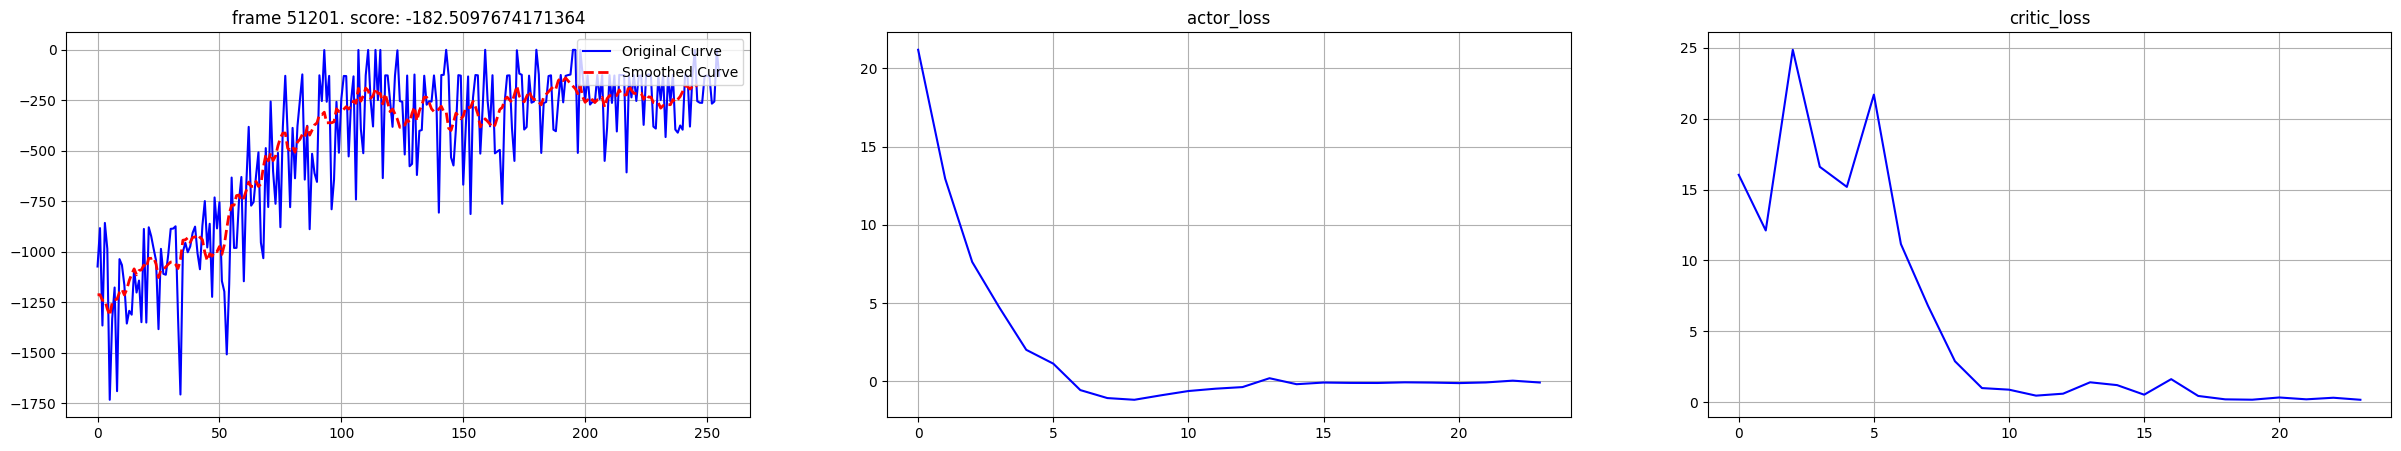

In [19]:
ppo_agent.train(num_frames)

## Train DDPG

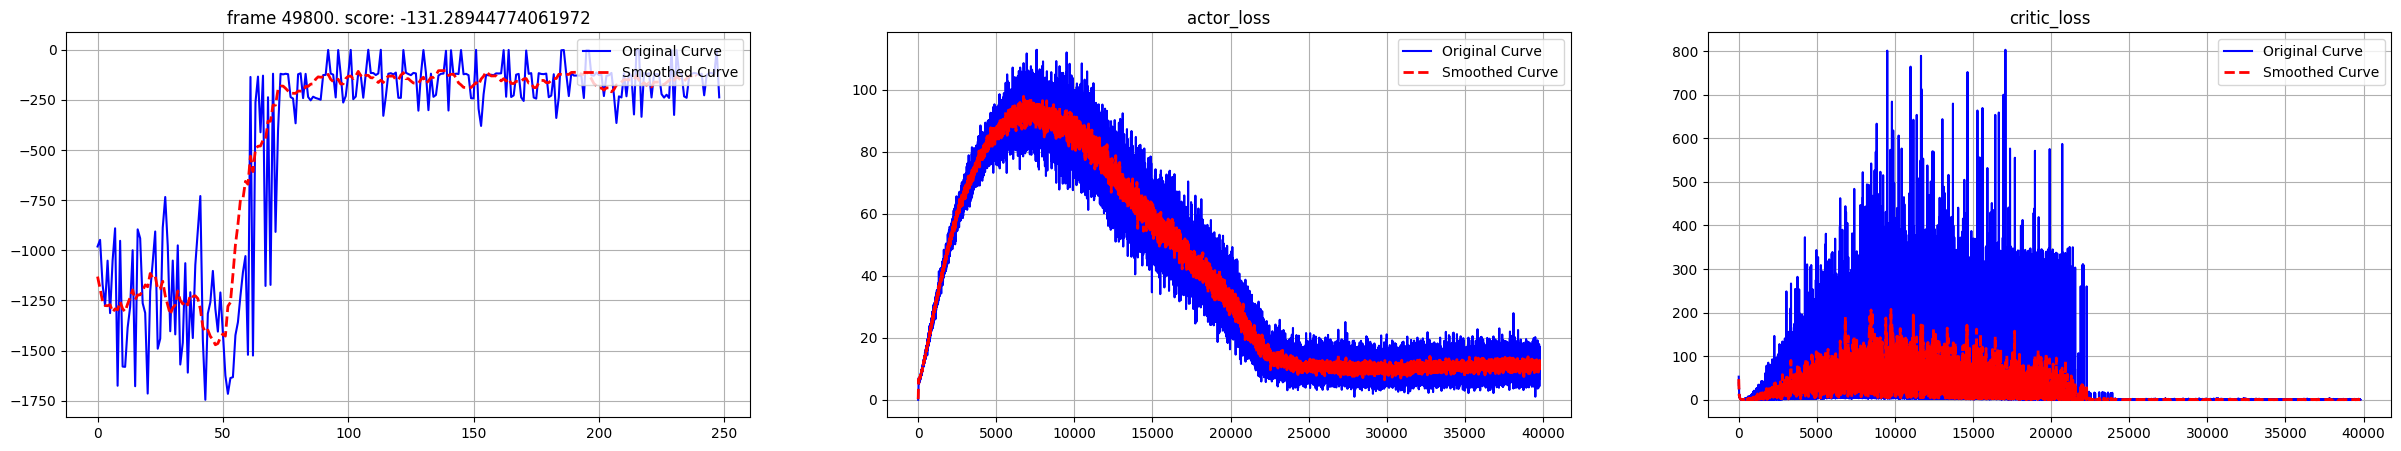

In [20]:
ddpg_agent.train(num_frames)

## Testing the PPO-agent

In [39]:
import gym
from gym.wrappers.record_video import RecordVideo

# Define the path to the video file
path = "./videos"

# Wrap the environment with a RecordVideo wrapper to record the video
env = RecordVideo(env, path)

# Run the environment for some time
obs = env.reset()
done = False
while not done:
    action = ppo_agent.select_action(obs)
    obs, reward, done, info = env.step(action)

# Close the environment and save the video
env.close()

from IPython.display import HTML
from base64 import b64encode


# Read the video file and encode it as base64
with open(path + '/' + "rl-video-episode-0.mp4", "rb") as f:
  video_encoded = b64encode(f.read()).decode('utf-8')

# Create an HTML tag that displays the video using base64 encoding
HTML("""
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  </video>
""".format(video_encoded))

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mo

## Testing the DDPG agent

In [40]:
import gym
from gym.wrappers.record_video import RecordVideo

# Define the path to the video file
path = "./videos"

# Wrap the environment with a RecordVideo wrapper to record the video
env = RecordVideo(env, path)

# Run the environment for some time
obs = env.reset()
done = False
while not done:
    action = ddpg_agent.select_action(obs)
    obs, reward, done, info = env.step(action)

# Close the environment and save the video
env.close()

from IPython.display import HTML
from base64 import b64encode


# Read the video file and encode it as base64
with open(path + '/' + "rl-video-episode-0.mp4", "rb") as f:
  video_encoded = b64encode(f.read()).decode('utf-8')

# Create an HTML tag that displays the video using base64 encoding
HTML("""
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  </video>
""".format(video_encoded))

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mo